In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
problem = 'Animals'
train = pd.read_csv('data/' + problem + '/train.csv')
#train.head()

# Visualizing and preprocessing the data

### Drop useless features

In [170]:
train.drop(['OutcomeSubtype', 'AnimalID'], axis=1, inplace=True)

### Explore the data a little...

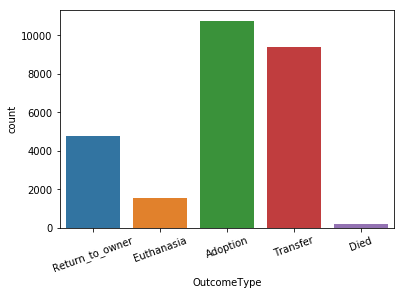

In [171]:
ax = sns.countplot(train.OutcomeType)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

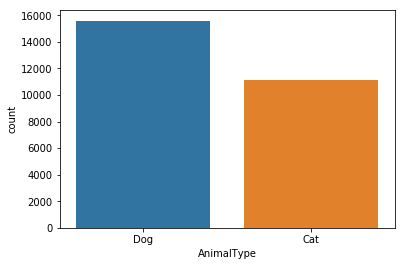

In [172]:
sns.countplot(train.AnimalType)

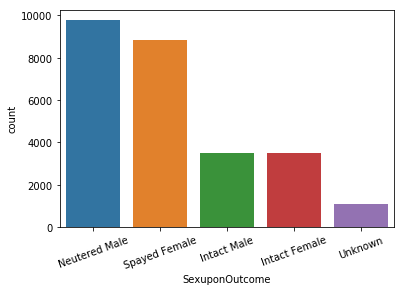

In [173]:
ax = sns.countplot(train.SexuponOutcome)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

### Generate new features from existing ones

In [174]:
def process_name(df):
    df['HasName'] = 1
    df.loc[df.Name.isnull(), 'HasName'] = 0

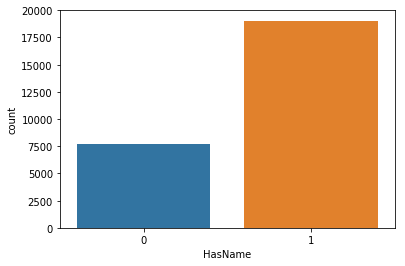

In [175]:
process_name(train)
sns.countplot(train.HasName)

In [176]:
def process_sex(x):
    x = str(x)
    if 'Male' in x:
        return 'Male'
    elif 'Female' in x:
        return 'Female'
    return 'Unknown'
    
def process_sterilization(x):
    x = str(x)
    if ('Spayed' in x) or ('Neutered' in x):
        return 'Sterilized'
    elif 'Intact' in x:
        return 'Intact'
    return 'Unknown'

In [177]:
train['Sex'] = train.SexuponOutcome.apply(process_sex)
train['Sterilized'] = train.SexuponOutcome.apply(process_sterilization)

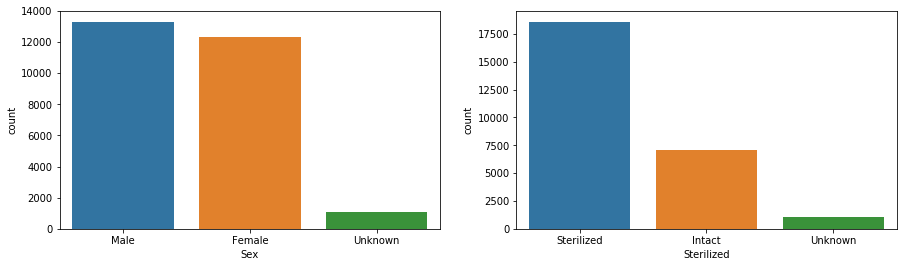

In [178]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(train.Sex, ax=ax1)
sns.countplot(train.Sterilized, ax=ax2)

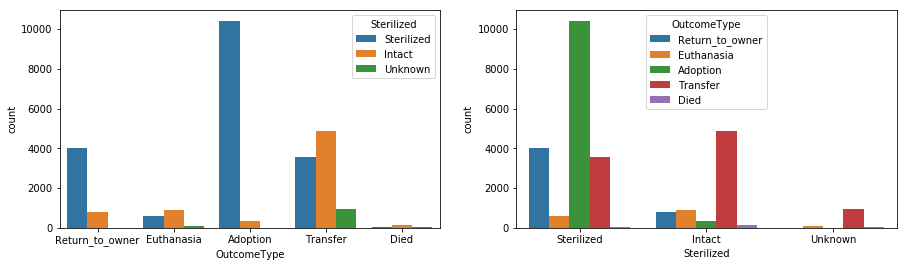

In [179]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(data=train, x='OutcomeType', hue='Sterilized', ax=ax1)
sns.countplot(data=train, x='Sterilized', hue='OutcomeType', ax=ax2)

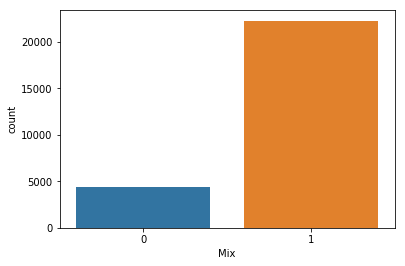

In [180]:
train['Mix'] = train.Breed.apply(lambda x: int(str(x).endswith('Mix')))
train['Breed'] = train.Breed.str.rstrip(' Mix')
sns.countplot(train.Mix)

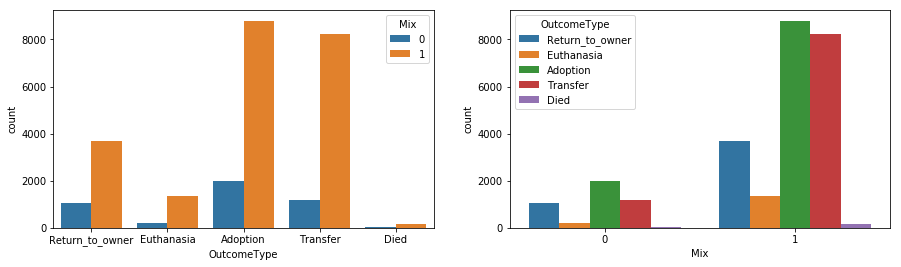

In [181]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(data=train, x='OutcomeType', hue='Mix', ax=ax1)
sns.countplot(data=train, x='Mix', hue='OutcomeType', ax=ax2)

In [182]:
def process_age(age):
    days_in_unit = {
        'day': 1,
        'days': 1,
        'week': 7,
        'weeks': 7,
        'month': 30,
        'months': 30,
        'years': 365,
        'year': 365
    }

    if not isinstance(age, str): return float('nan')
    age = age.split(' ')
    return int(age[0]) * days_in_unit[age[1]]

train['Age'] = train['AgeuponOutcome'].map(process_age) / 365

Impute mean/median values intead of NaNs

In [183]:
def impute_age(src, dst):
    for f, g in dst.loc[dst['Age'].isnull()].groupby(['Breed', 'Mix', 'Sex']):
        gtrain = src.loc[
                (src['Breed'] == f[0]) &
                (src['Mix'] == f[1]) &
                ( (src['Sex'] == f[2]) ), # if f[2] else True ),
            'Age']
        med, cnt = gtrain.median(), gtrain.count()
        if cnt < 30: med = gtrain.mean()
        dst.loc[dst['Age'].isnull() &
             (dst['Breed'] == f[0]) &
             (dst['Mix'] == f[1]) &
             (dst['Sex'] == f[2]),
                'Age'] = med
        #print('Imputed age %s from %s samples of %s %s %s' % (
        #      med, cnt,
        #      f[0],
        #     'Mix' if f[1] else '',
        #     'Male' if f[2] == 0 else ('Female' if f[2] == 1 else 'Bisexual')))

In [184]:
impute_age(train, train)

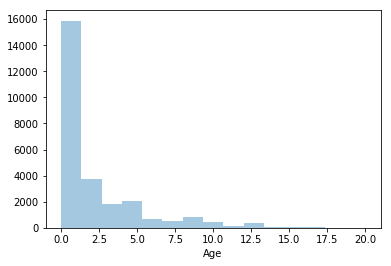

In [185]:
sns.distplot(train.Age, bins = 15, kde=False)

In [186]:
def get_age_category(x):
    if x < 0.84: return 'Newborn'
    if x < 1: return 'Child'
    if x < 6: return 'Teen'
    if x < 11: return 'Adult'
    return 'Old'
train['AgeCategory'] = train.Age.apply(get_age_category)
train['YoungAge'] = train.Age.apply(lambda x: int(x < 3))

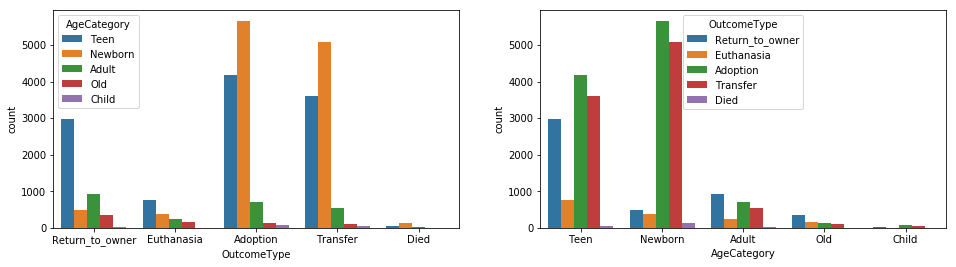

In [187]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)

In [188]:
def hour_to_time_of_day(h):
    if h >= 5 and h < 11:
        return 'Morning'
    elif h >= 11 and h < 16:
        return 'Midday'
    elif h >= 16 and h < 20:
        return 'Evening'
    return 'Night'

In [189]:
import dateutil

def process_date(df):
    df['Year'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).year)
    df['Month'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).month)
    df['Day'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).day)
    df['Hour'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).hour)
    df['Weekday'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).weekday())
    df['TimeOfDay'] = df.Hour.apply(hour_to_time_of_day)

In [190]:
process_date(train)

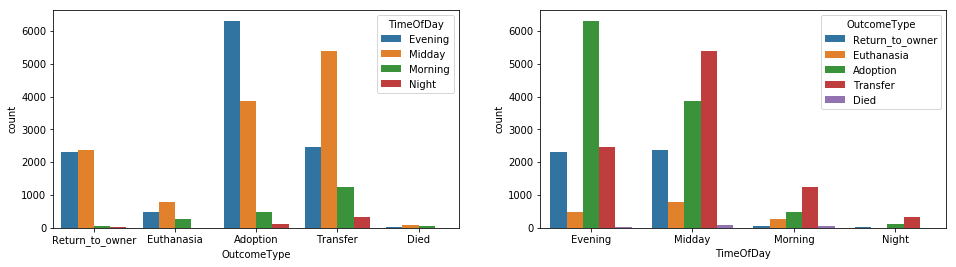

In [191]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='TimeOfDay', ax=ax1)
sns.countplot(data=train, x='TimeOfDay',hue='OutcomeType', ax=ax2)

In [192]:
import re
train['SimpleColor'] = train.Color.apply(lambda x: re.split('/| ', x)[0])

In [194]:
train['SimpleBreed'] = train.Breed.apply(lambda x: re.split('/', x)[0])
popular_breed = train.SimpleBreed.value_counts()[0:25].index.tolist()
train.SimpleBreed = train.SimpleBreed.apply(lambda x: x if x in popular_breed else 'Rare')

In [223]:
features = ['AnimalType', 'HasName', 'Sterilized',\
       'Age', 'Month', 'Day', 'Hour',\
       'Weekday', 'TimeOfDay', 'SimpleColor', 'AgeCategory', 'SimpleBreed'] #  'Year', 'Sex', 

X = train[features]
y = train['OutcomeType']

In [224]:
from sklearn.preprocessing import LabelEncoder

encoded = ['AnimalType', 'Sterilized',\
           'TimeOfDay', 'AgeCategory', 'SimpleColor', 'SimpleBreed'] #'Sex', 
encoders = {}

for col in encoded:
    e = LabelEncoder()
    encoders[col] = e
    X[col] = e.fit_transform(X[col])

y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Training

In [225]:
# fix random seed for reproducibility
import numpy as np
seed = 7
np.random.seed(seed)

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=seed)

## Logistic Regression

In [104]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

degree = 2

logfit = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree)), 
    ('clf', LogisticRegression())])

scores = model_selection.cross_val_score(logfit, X, y, scoring='neg_log_loss')
print('score: %s' % -scores.mean())

score: 0.840396894437


In [ ]:
logfit.fit(X, y)

## KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

params = { 
    #'n_neighbors': [x for x in range(10, 100, 4)],
    #'weights': ['uniform', 'distance'],
    #'p': [1,2],
}

knn = model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring='neg_log_loss')
knn.fit(X_train, y_train);

print('Best params for knn: ', knn.best_params_)
print('Best score: ', -knn.best_score_)

Best params for knn:  {}
Best score:  5.44667002374


## Random Forest

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [1200, 500, 300, 120, 800], # 
    'max_depth': [30, 15, 5, 8, 25, None], # 
    'min_samples_split': [15, 2, 5, 10, 100], # 
    'min_samples_leaf': [2,1,10, 5], # 
    'max_features': ['sqrt','log2', None] #
}

forest = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='neg_log_loss')
forest.fit(X, y);

print('Best params: ', forest.best_params_)
print('Best score: ', -forest.best_score_)

Best params:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500}
Best score:  0.781331203384


Feature ranking:
1. Sterilized (0.208309)
2. Age (0.185524)
3. Hour (0.102302)
4. HasName (0.080814)
5. Day (0.074246)
6. Weekday (0.059802)
7. SimpleBreed (0.059402)
8. Month (0.058648)
9. SimpleColor (0.046032)
10. TimeOfDay (0.044962)
11. AgeCategory (0.042588)
12. AnimalType (0.037372)


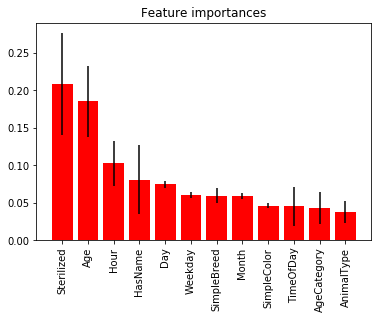

In [217]:
importances = forest.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
mapper = np.vectorize(lambda x: features[x])
plt.xticks(range(X.shape[1]), mapper(indices), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## NN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
from keras.utils import np_utils

def pre_nn(X, y):
    # encode class values as integers
    encoder = LabelEncoder()
    encoded_Y = encoder.fit_transform(y)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    X_new = StandardScaler().fit_transform(X)
    return (X_new, dummy_y)

In [ ]:
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

xx, yy = pre_nn(X_train, y_train)
estimator.fit(xx, yy)

In [ ]:
from sklearn.metrics import log_loss

xx, yy = pre_nn(X_validation, y_validation)
pred = estimator.predict_proba(xx)

#log_loss(pred, y_validation)

# Submit to Kaggle

In [215]:
test = pd.read_csv('data/' + problem + '/test.csv')
process_name(test)
test['Sex'] = test.SexuponOutcome.apply(process_sex)
test['Sterilized'] = test.SexuponOutcome.apply(process_sterilization)
test['Mix'] = test.Breed.apply(lambda x: int(str(x).endswith('Mix')))
test['Breed'] = test.Breed.str.rstrip(' Mix')
test['Age'] = test['AgeuponOutcome'].map(process_age) / 365
impute_age(train, test)
test['AgeCategory'] = test.Age.apply(get_age_category)
test['YoungAge'] = test.Age.apply(lambda x: int(x < 3))
process_date(test)
test['SimpleColor'] = test.Color.apply(lambda x: re.split('/| ', x)[0])
test['SimpleBreed'] = test.Breed.apply(lambda x: re.split('/', x)[0])
test.SimpleBreed = test.SimpleBreed.apply(lambda x: x if x in popular_breed else 'Rare')

X_test = test[features]


for col in encoded:
    X_test[col] = encoders[col].transform(X_test[col])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [96]:
from sklearn.preprocessing import label_binarize

def submit(clf, name):
    predicts = clf.predict_proba(X_test)
    ids = test.ID
    
    answers = pd.DataFrame(predicts)
    answers = pd.concat([ids, answers], axis=1)
    answers.columns = ['ID', 'Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
    answers.to_csv(name + '.csv', index=False)

In [97]:
#submit(logfit, 'logfit_poly_degree_' + str(degree))

In [216]:
submit(forest, 'forest')

In [ ]:
#submit(rf, 'rf')